# NOAA Sea Surface Temperature Data Analysis

The National Oceanographic and Atmospheric Association, NOAA, has dedicated scientists and advanced technology to provide reliable information about changes in climate, weather, oceans and coasts. Such information can be found online and it's available to the public. The NOAA dataset 'International Comprehensive Ocean-Atmosphere Data Set ICOADS' was used for this project. The dataset can be found in Google Cloud's [Marketplace](https://console.cloud.google.com/marketplace), and it has the following description:

> "The ICOADS dataset contains global marine data from ships (merchant, navy, research) and buoys, each capturing details according to the current weather or ocean conditions (wave height, sea temperature, wind speed, and so on). Each record contains the exact location of the observation which is great for visualizations. The historical depth of the data is quite comprehensive — there are records going back to 1662.
This public dataset is hosted in Google BigQuery and is included in BigQuery's 1TB/mo of free tier processing. This means that each user receives 1TB of free BigQuery processing every month, which can be used to run queries on this public dataset." 

Google BigQuery allows the database to be explored and manipulated using SQL queries. In this case, we want to explore the average sea surface temperature for the duration of 67 years, extending from the year 1950 to the year 2017. The main objective is to visualize the changes in sea surface temperature as a function of time.

Project Methods:

- Query the database using SQL to extract the data
- Export the results of the query into a readable Python format.
- Visualize important features in the data.
- Use machine learning methods to predict future sea surface temperatures.

In [1]:
#Import the json file with the credentials to the GCP project
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='your_credential_file.json' # Insert your google credentials json file

import numpy as np
import pandas as pd # Useful if you need to view a table as a pandas dataframe


from google.cloud import bigquery

client = bigquery.Client()

# Construct a reference to the "noaa_icoads" dataset
dataset_ref = client.dataset("noaa_icoads", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

#List the tables in the dataset
[table.table_id for table in list(client.list_tables(dataset))]

['icoads_core_1662_2000',
 'icoads_core_2001_2004',
 'icoads_core_2005',
 'icoads_core_2006',
 'icoads_core_2007',
 'icoads_core_2008',
 'icoads_core_2009',
 'icoads_core_2010',
 'icoads_core_2011',
 'icoads_core_2012',
 'icoads_core_2013',
 'icoads_core_2014',
 'icoads_core_2015',
 'icoads_core_2016',
 'icoads_core_2017']

In [2]:
# Construct a reference to the "international_education" table
table_ref = dataset_ref.table("icoads_core_2017")

# API request - fetch the table
table = client.get_table(table_ref)

#View all columns of the table using .schema
table.schema

[SchemaField('year', 'INTEGER', 'NULLABLE', 'Year of the actual time of observation at which the barometer is read. It is 4-digit', ()),
 SchemaField('month', 'INTEGER', 'NULLABLE', 'Month of the actual time of observation at which the barometer is read. (1=January, 2=February, …, 12=December)', ()),
 SchemaField('day', 'INTEGER', 'NULLABLE', 'Day of the actual time of observation at which the barometer is read. Days 1-31', ()),
 SchemaField('hour', 'FLOAT', 'NULLABLE', 'Hour of the actual time of observation at which the barometer is read. Hours 0.00 to 23.99', ()),
 SchemaField('latitude', 'FLOAT', 'NULLABLE', 'Position to hundredths of a degree +N or –S (measured north or south of the equator) and +E or −W (measured east or west of the Greenwich Meridian).', ()),
 SchemaField('longitude', 'FLOAT', 'NULLABLE', 'Position to hundredths of a degree +N or –S (measured north or south of the equator) and +E or −W (measured east or west of the Greenwich Meridian).', ()),
 SchemaField('imma_

In [3]:
# Check teh number of rows
print("Number of rows in table'",table.table_id,"' is",f'{table.num_rows :,}'+'.') # use f{number:,} to give k format

Number of rows in table' icoads_core_2017 ' is 31,036,992.


In [4]:
# Check number of columns
print("Number of columns in table '",table.table_id,"' is",str(len(table.schema))+'.')

Number of columns in table ' icoads_core_2017 ' is 75.


### Write an SQL query to get the data 

The `ROW_NUMBER()` function is used to select the rank of top temperatures for each year and month.

In [5]:
#To load the magic commands from the client library, run the following code
%load_ext google.cloud.bigquery

In [6]:
%%bigquery temps_df 
#save result in a pandas dataframe named temps_df

WITH top_temps_pre AS (   
    SELECT year, month, latitude, longitude, AVG(sea_surface_temp) AS sstemp, 
       ROW_NUMBER() OVER (PARTITION BY year ORDER BY AVG(sea_surface_temp) DESC) AS temp_rank
    FROM `bigquery-public-data.noaa_icoads.icoads_core_*`  # Use wildcard * to explore all tables
    WHERE (sea_surface_temp IS NOT NULL) AND (year BETWEEN 1950 AND 2018)
    GROUP BY year, month, longitude, latitude
)


SELECT year, month, latitude, longitude, sstemp, temp_rank
FROM top_temps_pre
WHERE temp_rank <= 200000
ORDER BY sstemp

     
#Rank query
    
# WITH top_temps_pre AS (   
#     SELECT year, latitude, longitude, sea_surface_temp, 
#        RANK() OVER (PARTITION BY year ORDER BY sea_surface_temp DESC) AS temp_rank
#     FROM `bigquery-public-data.noaa_icoads.icoads_core_*` 
#     WHERE (sea_surface_temp IS NOT NULL) AND (year BETWEEN 1950 AND 2018)
#     ORDER BY sea_surface_temp DESC
# )

### Create an animated map showing the data that resulted from the query

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from IPython.display import HTML # import in case you want to display in the jupyter notebook
from matplotlib.animation import FuncAnimation, PillowWriter

# The key 'PROJ_LIB' needs to be imported so Basemap can be imported
import os
os.environ['PROJ_LIB'] = r'C:\Users\joman\Anaconda3\pkgs\proj4-5.2.0-h6538335_1006\Library\share'

from mpl_toolkits.basemap import Basemap
from numpy import max

# Group by year, discard the 'month' column
temps_year = temps_df[['year', 'latitude', 'longitude', 'sstemp']].groupby(['year','longitude',
                                                                            'latitude']).mean()
# Remove the multilevel index by resetting the index                                                                            'longitude', 'latitude']).mean()
temps_year = temps_year.reset_index(level=[0,1,2])


def update(year):
    '''Function to pass to the matplotlib FuncAnimation() function. Each frame of the animation
    will be a different year, so this function will 'update' each frame according to the year.
    Make sure that the list of frames passed to the FuncAnimation is a list of the years.'''
    
    fig.clf()
    
    m = Basemap(llcrnrlat=-80,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,
                lat_ts=20, resolution='c', projection='mill', lat_0 = 0, lon_0 = 0)
    m.drawcoastlines(color='#111111')
    m.fillcontinents(color='#111111')
    
    lat  = np.array(temps_year[temps_year['year']==year]['latitude'])
    lon  = np.array(temps_year[temps_year['year']==year]['longitude'])
    temp = np.array(temps_year[temps_year['year']==year]['sstemp'])
    
    x,y = m(lon,lat)
    
    m.hexbin(x, y,C= np.array(temp), reduce_C_function = max, gridsize=100,vmin=5,vmax=39,
             cmap='jet', linewidths=0.1, edgecolors='k'), 
    m.colorbar(location='right').set_label('C°',fontsize=14,rotation='horizontal',position=(0,1),labelpad=15)

    text_x, text_y = m(77, -77)

    plt.text(text_x,text_y, '%d'%year,fontsize=29,fontweight='bold',ha='left',va='bottom',color='white')
    plt.text(text_x-3200000,text_y, 'year',fontsize=19,fontweight='bold',ha='left',va='bottom',color='white')


__Map 1.__ Animation showing the change in the top average sea surface temperatures by location by year, from the years 1950 to 2017. As it is expected, the area along the equator has the highest average temperatures. Notice how the year 1950 has more lower temperatures and more locations on the top average temperatures than the year 2017. Each year has the top 200,000 readings averaged by location. With this in mind, the animation is showing an increase in sea surface temperature. The area in the Red Sea and the Persian Gulf stand out as the hotter places across all years.

In [8]:
# fig = plt.figure(figsize=(12, 6.4))
# fig.subplots_adjust(left=0.01, bottom=0, right=0.95, top=1, wspace=None, hspace=None)

# frames = temps_year['year'].value_counts().index.sort_values() #List of frames are integers (the years 1950 - 2017)

# # Call the FuncAnimation() function to create the animation. Use PillowWriter writer to create the .gif file
# ani = FuncAnimation(fig, update, frames=frames,interval=600)
# ani.save('fig.gif', writer=PillowWriter(fps=1))
# plt.close()

### Change of the highest averages per year and per location

For the range of 67 years for which the yearly sea surface temperature average was calculated, the following chart shows how the highest averages has changed.

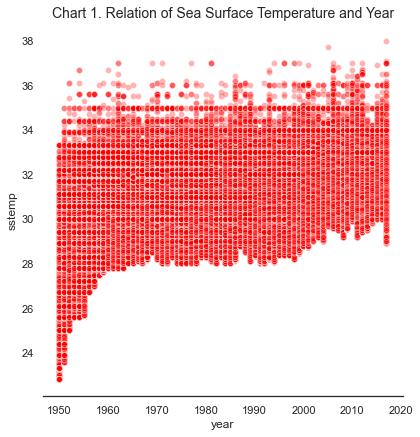

In [9]:
import seaborn as sns
%matplotlib inline

sns.set(style="white", palette="muted", color_codes=True)

sns.relplot(x="year", y="sstemp", color='red', alpha=0.3, data=temps_year,height=6)
sns.despine(left=True)
plt.title('Chart 1. Relation of Sea Surface Temperature and Year',fontsize=14)
plt.show()

**Chart 1**. Each point is a map coordinate that had one of the 200'000 top temperature averages for each year. The highest average temperatures in 1950 are more spread and range almost from the low 20s to the mid 30s. As years increase, average temperatures increase and comprise a lower range ending in between the top 20s to the mid 30s. The lowest top averages (bottom points in each year) increase as well. This is why we see more blue colored areas in Map 1 for the year 1950 and a concentration of high temperatures in determined areas for the year 2017. 

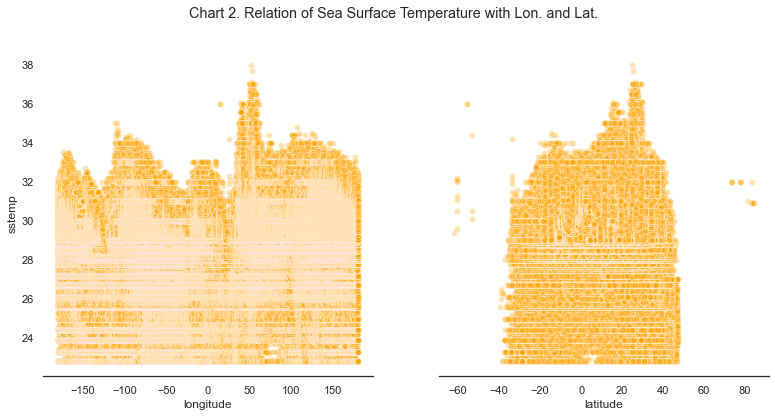

In [10]:
# Plot relation of temperature with latitude and longitude
fig, axs = plt.subplots(1,2,figsize=(13, 6), sharey=True)
sns.relplot(x="longitude", y="sstemp", data=temps_year, color='orange', alpha=0.3, ax=axs[0])
sns.despine(left=True, ax=axs[0])
sns.relplot(x="latitude", y="sstemp", data=temps_year, color='orange', alpha=0.3, ax=axs[1])
sns.despine(left=True, ax=axs[1])
fig.suptitle('Chart 2. Relation of Sea Surface Temperature with Lon. and Lat.')
plt.close(2)
plt.close(3)
plt.show()

**Chart 2.** By changing the longitude there isn't much change for each temperature point. Longitudes, the imaginary lines moving East to West around Earth don't vary a lot. Latitudes (lines going North to South), on the other hand, show different temperatures according to the value. Latitudes on the equator have higher temperatures than those in the Northern and Southern Hemispheres. 

## Methods of data collection for sea surface temperature

The temperature data was collected by different observation platforms using different methods. As an informative addition, here are the most used platforms and methods set appart. 

### Platforms used
Each platform is numbered in the NOAA database from 0 to 21 with the following legend:

- 0 : US Navy or “deck” log, or unknown
- 1 : merchant ship or foreign military
- 2 : ocean station vessel—off station or station proximity unknown
- 3 : ocean station vessel—on station
- 4 : lightship
- 5 : ship
- 6 : moored buoy
- 7 : drifting buoy
- 8 : ice buoy (note: currently unused)
- 9 : ice station (manned, including ships overwintering in ice)
- 10 : oceanographic station data (bottle and low-resolution CTD/XCTD data)
- 11 : mechanical/digital/micro bathythermograph (MBT)
- 12 : expendable bathythermograph (XBT)
- 13 : Coastal-Marine Automated Network (C-MAN) (NDBC operated)
- 14 : other coastal/island station
- 15 : fixed (or mobile) ocean platform (plat, rig)
- 16 : tide gauge
- 17 : high-resolution Conductivity-Temp.-Depth (CTD)/Expendable CTD (XCTD) 74 
- 18 : profiling float
- 19 : undulating oceanographic recorder
- 20 : autonomous pinneped bathythermograph
- 21 : glider

With this information, we can examine which platforms were used for the collection of data for the sea surface temperature from the years 1950 to 2017. The ICOADS dataset will be queried again to retrieve the information needed.

In [11]:
%%bigquery sources_df
#save result in a pandas dataframe named sources_df
     
WITH sources AS (   
    SELECT year, latitude, longitude, sea_surface_temp, platform_type, sst_measurement_method
    FROM `bigquery-public-data.noaa_icoads.icoads_core_*` 
    WHERE (sea_surface_temp IS NOT NULL) AND (year BETWEEN 1950 AND 2018) AND (platform_type IS NOT NULL)
),

sources_summary AS (
    SELECT year, latitude, longitude, AVG(sea_surface_temp) AS sstemp, platform_type, sst_measurement_method
    FROM sources
    GROUP BY year, longitude, latitude, platform_type, sst_measurement_method
    ORDER BY sstemp DESC
)
    
SELECT CAST(platform_type AS STRING) AS code_name, COUNT(*) AS count, 'platform type' AS column_name
FROM sources_summary
GROUP BY platform_type

UNION ALL

SELECT CAST(sst_measurement_method AS STRING) AS code_name, COUNT(*) AS count, 'method' AS column_name
FROM sources_summary
GROUP BY sst_measurement_method

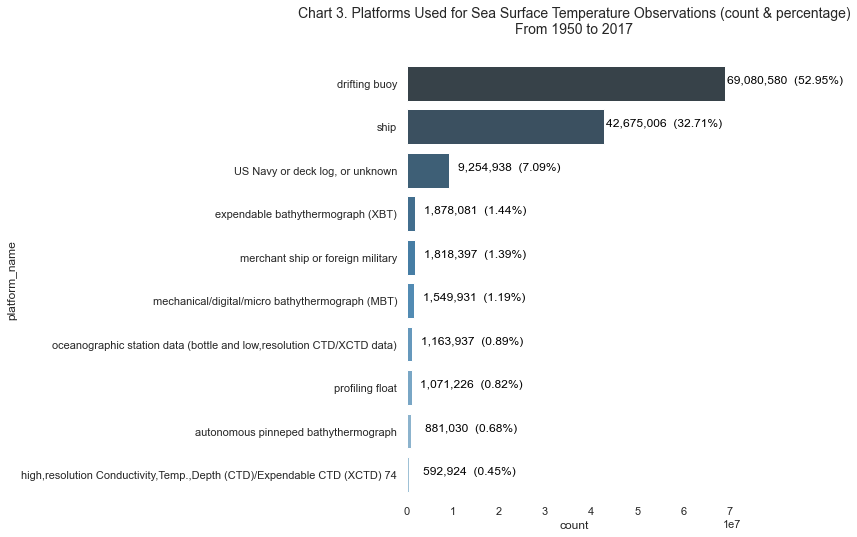

In [12]:
# Plot the data

# Filter only the platforms from the sources_df dataframe, then sort the count.
platforms_count = sources_df[sources_df['column_name']== 'platform type'].sort_values('count',ascending=False) 

# Organize all platform names with their NOAA number in a dictionary
platform_types = {0 : 'US Navy or deck log, or unknown',
    1 : 'merchant ship or foreign military', 
    2 : 'ocean station vessel—off station or station proximity unknown',   
    3 : 'ocean station vessel—on station', 
    4 : 'lightship', 
    5 : 'ship', 
    6 : 'moored buoy', 
    7 : 'drifting buoy', 
    8 : 'ice buoy (note: currently unused)', 
    9 : 'ice station (manned, including ships overwintering in ice)', 
    10 : 'oceanographic station data (bottle and low,resolution CTD/XCTD data)', 
    11 : 'mechanical/digital/micro bathythermograph (MBT)', 
    12 : 'expendable bathythermograph (XBT)', 
    13 : 'Coastal,Marine Automated Network (C,MAN) (NDBC operated)', 
    14 : 'other coastal/island station', 
    15 : 'fixed (or mobile) ocean platform (plat, rig)', 
    16 : 'tide gauge', 
    17 : 'high,resolution Conductivity,Temp.,Depth (CTD)/Expendable CTD (XCTD) 74' , 
    18 : 'profiling float', 
    19 : 'undulating oceanographic recorder', 
    20 : 'autonomous pinneped bathythermograph', 
    21 : 'glider'}

def name_platform(n):
    for p in platform_types:
        if n == str(p):
            return platform_types[p]
    else:
        return 'None'

def percentage(c):
    per = (c/platforms_count['count'].sum())*100
    return per
    

# Apply functions
platforms_count['platform_name'] = platforms_count['code_name'].apply(name_platform)
platforms_count['%'] = platforms_count['count'].apply(percentage)


plt.figure(figsize=(6,8))
platforms_chart = sns.barplot(x="count",
                         y="platform_name",
                         palette='Blues_d',
                         data=platforms_count[:10], dodge=False
                         )

plt.title('Chart 3. Platforms Used for Sea Surface Temperature Observations (count & percentage)\nFrom 1950 to 2017',
          y=1.05, fontsize=14)
# nyc_chart.get_legend().set_visible(False) #In case plot needs legend, this would hide the legend

# Loop to add text to each bar
for index, row in platforms_count[:10].reset_index(drop=True).iterrows():
    label = row['count']
    per = f"  ({row['%']:.2f}%)"
    platforms_chart.text(row['count']+13000000, index, f"{label:,}"+per, color='black', ha="center")

sns.despine(left=True, bottom=True)

### Methods used

The methods used for data gathering are classified by NOAA as follows:

- 0 – bucket 
- 1 – condenser inlet (intake) 
- 2 – trailing thermistor 
- 3 – hull contact sensor 
- 4 – through hull sensor 
- 5 – radiation thermometer 
- 6 – bait tanks thermometer 
- 7 – others 
- 9 – unknown or non-bucket 
- 10 – “implied” bucket [note: applicable to early ICOADS data] 
- 11 – reversing thermometer or mechanical sensor 
- 12 – electronic sensor

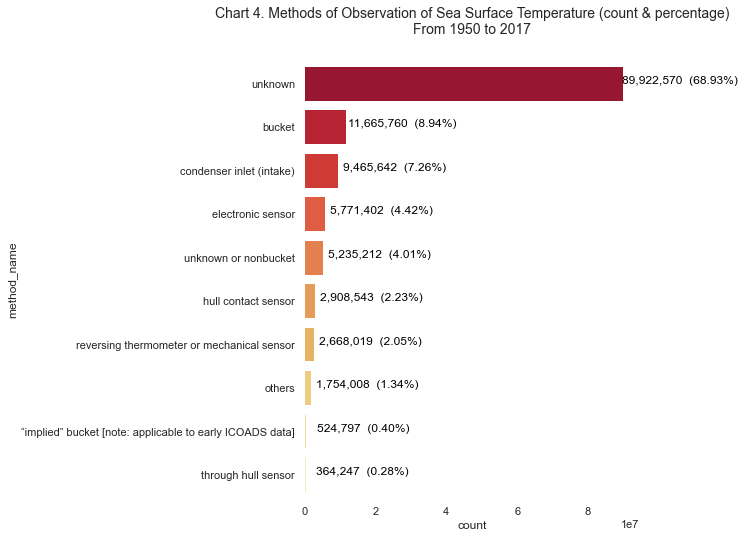

In [13]:
methods_count = sources_df[sources_df['column_name']=='method'].sort_values('count',ascending=False)

methods_key = { 0 : 'bucket', 
     1 : 'condenser inlet (intake)', 
     2 : 'trailing thermistor',
     3 : 'hull contact sensor', 
     4 : 'through hull sensor', 
     5 : 'radiation thermometer', 
     6 : 'bait tanks thermometer', 
     7 : 'others', 
     9 : 'unknown or nonbucket', 
     10 : '“implied” bucket [note: applicable to early ICOADS data]', 
     11 : 'reversing thermometer or mechanical sensor', 
     12 : 'electronic sensor'}

def get_method(x):
    for m in methods_key:
        if x == str(m):
            return methods_key[m]
    else:
        return 'unknown'
    
def percentage(c):
    per = (c/methods_count['count'].sum())*100
    return per
    
methods_count['method_name'] = methods_count['code_name'].apply(get_method)
methods_count['%'] = methods_count['count'].apply(percentage)

plt.figure(figsize=(6,8))
methods_chart = sns.barplot(x="count",
                         y="method_name",
                         palette='YlOrRd_r',
                         data=methods_count[:10], dodge=False
                         )

# Loop to add text to each bar
for index, row in methods_count[:10].reset_index(drop=True).iterrows():
    label = row['count']
    per = f"  ({row['%']:.2f}%)"
    methods_chart.text(row['count']+16000000, index, f"{label:,}"+per, color='black', ha="center")

plt.title('Chart 4. Methods of Observation of Sea Surface Temperature (count & percentage)\nFrom 1950 to 2017',
          y=1.05, fontsize=14)
sns.despine(left=True, bottom=True)

**Chart 4.** The 10 top methods used. Most of the data had null values for the method column, so that is why the top value is marked as 'unknown'. NOAA has no explanation yet as to why most of this values are missing, but there had to be a method used or else there could've not been a reading in the temperature value.

## Create a machine learning model to predict future changes

Sea surface temperature (SST) is a fundamental physical variable for understanding, quantifying and predicting complex interactions between the ocean and the atmosphere. Such processes determine how heat from the sun is redistributed across the global oceans, directly impacting large- and small-scale weather and climate patterns.

An important region of the Pacific Ocean, known as the 'Niño 3.4' region, shows how higher sea surface temperatures can affect the climate. Here we create a machine learning model to try to predict the sea surface temperature for the next couple of years after 2017, the last year in the dataset. According to the NASA Earth Observatory [website](https://earthobservatory.nasa.gov/features/ElNino), that region lies in a longitude between 120 West and 170 West. The latitude is between 20 North and 20 South.

Through a long short-term memory recurrent (LSTM) neural network for multi-step time series forecasting we can get a model that predicts several time-steps into the future.


### Predict the next 12 months given the last 48 months</strong>

Using a [Tensorflow](https://www.tensorflow.org/) machine learning model, we can try and make a prediction for the average temperature for the next 12 months after the last date in the dataset for the Niño 3.4 Pacific region. The last average value is from August 2017, so the model will predict the next 12 months starting in September 2017.

In [17]:
# Filter the data
#Create dataset with avg monthly temperatures in the Pacific Ocean equator (120W - 170W)

pacific_temps_df = temps_df[(temps_df['longitude']<-120) & (temps_df['longitude']>-170) 
                            & (temps_df['latitude']>-20) & (temps_df['latitude']<20)]


#Create final univariate dataset with month temp average
TRAIN_SPLIT = 51
model_df = pacific_temps_df[['year','month','sstemp']].groupby(['year','month']).mean()
model_df = model_df['sstemp'].values

#Standarize all data using the training mean and std
# model_train_mean = model_df[:TRAIN_SPLIT].mean()
# model_train_std = model_df[:TRAIN_SPLIT].std()

# model_df = (model_df-model_train_mean)/model_train_std

### Check for any outliers in the data before trying a model

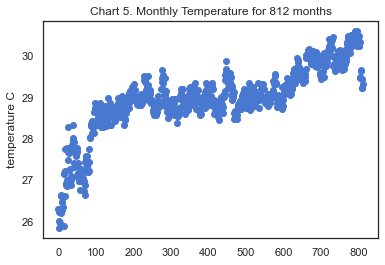

In [18]:
plt.scatter(range(len(model_df)),model_df)
plt.title('Chart 5. Monthly Temperature for 812 months')
plt.ylabel('temperature C')
plt.show()

**Chart 5.** This chart counts the highest readings in the Central pacific region for 812 months, starting from January of 1950 until August of 2017. There are no outliers in the data because all points lie between a reasonable range of 25 C° and 31 C°. This chart is also showing an upward trend in temperature readings. 

### Prepare the data to be introduced in the model

A function is needed to create the arrays needed to fit the machine learning model.

In [19]:
#Create a training and testing set
train_seq = model_df[:752]
test_seq = model_df[752:]

#Divide the data into historic x and their respective y predictions
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 48, 12
# split into samples
x_train, y_train = split_sequence(train_seq, n_steps_in, n_steps_out)
x_val, y_val = split_sequence(test_seq, n_steps_in, n_steps_out)

In [20]:
#Reshape arrays

n_features = 1
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], n_features))

### Create and fit the model
Since 12 predictions are being made, then the Dense layer has argument 12. There must not be shuffling of the data because that will disturb the time series order.


In [22]:
import tensorflow as tf
tf.random.set_seed(13)

# Create model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(128,return_sequences=True,
                                          input_shape=x_train.shape[-2:])) #input shape past_history, num of features
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(12))

multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')

multi_step_history = multi_step_model.fit(x_train, y_train, epochs=20,
                                        batch_size=16,
                                        validation_split=0.1,
                                        verbose=2,
                                        shuffle=False)


Train on 623 samples, validate on 70 samples
Epoch 1/15
623/623 - 30s - loss: 832.8859 - val_loss: 863.2051
Epoch 2/15
623/623 - 17s - loss: 649.4492 - val_loss: 639.3821
Epoch 3/15
623/623 - 17s - loss: 387.0686 - val_loss: 292.5854
Epoch 4/15
623/623 - 18s - loss: 197.4570 - val_loss: 145.7445
Epoch 5/15
623/623 - 18s - loss: 92.4161 - val_loss: 63.0103
Epoch 6/15
623/623 - 18s - loss: 37.2699 - val_loss: 21.9562
Epoch 7/15
623/623 - 21s - loss: 11.7376 - val_loss: 5.6277
Epoch 8/15
623/623 - 19s - loss: 2.9373 - val_loss: 1.3124
Epoch 9/15
623/623 - 18s - loss: 0.9657 - val_loss: 0.5809
Epoch 10/15
623/623 - 18s - loss: 0.6956 - val_loss: 0.4984
Epoch 11/15
623/623 - 18s - loss: 0.6660 - val_loss: 0.4542
Epoch 12/15
623/623 - 17s - loss: 0.6640 - val_loss: 0.4657
Epoch 13/15
623/623 - 18s - loss: 0.6545 - val_loss: 0.4265
Epoch 14/15
623/623 - 18s - loss: 0.6544 - val_loss: 0.4432
Epoch 15/15
623/623 - 17s - loss: 0.6421 - val_loss: 0.4236


You can plot the training and validation loss across the number of epochs. If the lines continue to go down, it is fitting well. If the lines start going up, it is overfitting.

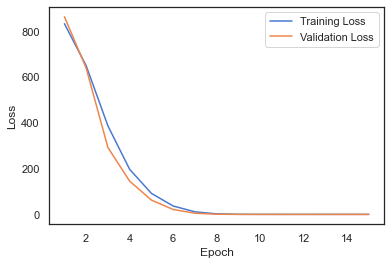

In [23]:
# Plot the training and validation loss
plt.plot(range(1,21),multi_step_history.history['loss'],label='Training Loss')
plt.plot(range(1,21),multi_step_history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Make a prediction using the validation set

In [24]:
y_hat = multi_step_model.predict(x_val)
y_hat

array([[29.36472 , 29.472084, 29.384434, 29.217299, 29.167498, 29.14871 ,
        29.344147, 29.331022, 29.331884, 29.423162, 29.3248  , 29.298918]],
      dtype=float32)

### Plot predicted versus true values

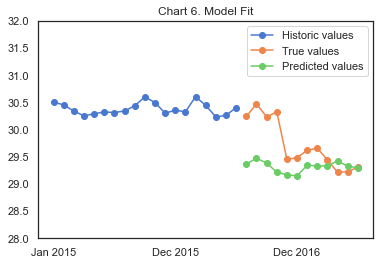

In [25]:
plt.plot(range(19),x_val[0][-19:],label='Historic values',marker='o')
plt.plot(range(19,31),y_val[0],label='True values',marker='o')
plt.plot(range(19,31),y_hat[0],label='Predicted values',marker='o')
plt.xticks(ticks=[0,12,24],labels=['Jan 2015','Dec 2015', 'Dec 2016'])
plt.ylim(28,32)
plt.title('Chart 6. Model Fit')
plt.legend()
plt.show()

The Chart above did predict a drop in temperature from around 30.5 C° to around 29.5 C°, but it predicted the drop would be in September 2016 instead of December of that year. Thus we have a model that is off for 1 C° in the first 4 months but then it gets a good fit for the next 8 months.

In [26]:
#Reshape the x values to 3 dimensions so the model can read them
latest_values = np.array([np.reshape(model_df[-48:], (48, 1))])

#Predict
prediction_2017 = multi_step_model.predict(latest_values)
prediction_2017

array([[29.301832, 29.38074 , 29.313843, 29.169828, 29.126158, 29.125044,
        29.289425, 29.27679 , 29.27078 , 29.359735, 29.26488 , 29.257084]],
      dtype=float32)

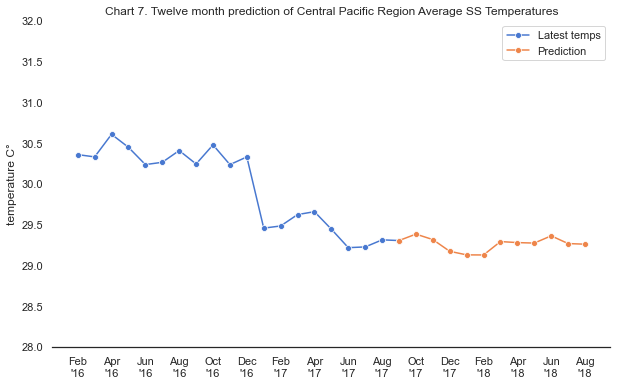

In [27]:
# Plot
# Import calendar to change month number to month name abbreviation
import calendar

# Get months from pacific_temps dataframe
years_months = pacific_temps_df[['year','month','sstemp']].groupby(['year','month']).mean()[-19:]
years = years_months.index.get_level_values('year')
# Add predicted years to list of years
years = list(years) + [2017]*4 + [2018]*8
months = years_months.index.get_level_values('month')
# Add predicted months to list of months
months = list(months) + [*range(9,13)] + [*range(1,10)]
# Create a list of x labels with all the months
x_labels = []
for i in range(len(months)):
    if i%2==0:
        x_labels.append(calendar.month_abbr[months[i]]+"\n'%s"%str(years[i])[2:]) 

y_history = model_df[-19:]
#Add first value of predicted y values as the last value of x to connect both lines in plot
y_history = np.insert(arr=y_history, obj=19, values=prediction_2017[0][0])




plt.figure(figsize=(10,6))
sns.lineplot(range(20),y_history,label='Latest temps',marker='o')
sns.lineplot(range(19,31),prediction_2017[0],label='Prediction',marker='o')
sns.despine(left=True)
plt.ylabel('temperature C°')
plt.title('Chart 7. Twelve month prediction of Central Pacific Region Average SS Temperatures')
plt.xticks(ticks=[*range(0,31,2)],labels=x_labels)
plt.ylim(28,32)
plt.show()

**Chart 4.** Prediction of the next 12 months after August 2017. Only 19 previous months are plotted of the 48 that were used to make the prediction. The year 2017 up until August shows a drop in temperatures compared to previous years. The prediction is indicating a rise  

### Plot the same figure as above but as an interactive chart using the plot.ly module

In [28]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[*range(20)],
    y=y_history,
    marker=dict(color="blue", size=12),
    mode="lines+markers",
    name="Latest temps",
    hovertemplate='%{y:.2f} C°'
))

fig.add_trace(go.Scatter(
    x=[*range(19,31)],
    y=prediction_2017[0],
    marker=dict(color="orange", size=12),
    mode="lines+markers",
    name="Predictions",
    hovertemplate='%{y:.2f} C°'
))

fig.update_layout(title={'font':{'size':14},
                         'text':"Chart 7. Twelve month prediction of Central Pacific Region Average SS Temperatures"},
                  yaxis_title="temperature C°",
                 autosize=False,
                 width=800,
                 height=450)
fig.update_xaxes(
    ticktext=x_labels,
    tickvals=[*range(0,31,2)]
#    tickangle=90
)

fig.update_yaxes(
    nticks=10
)

fig.show()

In [29]:
# Prepare your plotly plot to be embeded
import plotly.io as pio
import chart_studio.tools as tls

#Create HTML of plotly plot
# pio.write_html(fig, file='sstemps.html', auto_open=True) 

#Save the file in the _includes folder of your github page root. Embed using the line {% include sstemps.html %}